In [ ]:
# Import packages
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd

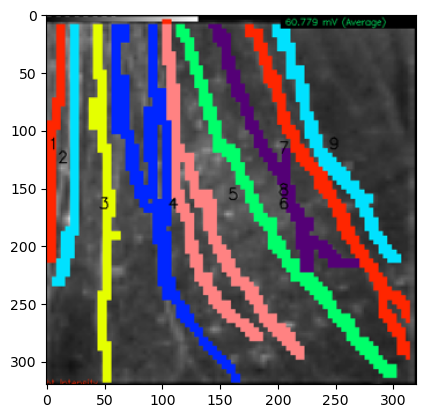

100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


In [19]:
data_type = 'Data101' # 'Data101' or 'Data240'
project_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'
calculate = False
visualize = False

data_dir = os.path.join(os.path.join(project_dir, 'data'), 'Fig5')
fig_dir = os.path.join(os.path.join(project_dir, 'figures'), 'Fig5')
background_path = os.path.join(data_dir, f'{data_type}.tif') 
image = Image.open(background_path).resize((320, 320))
backarr = np.array(image)

plt.imshow(backarr)
plt.show()

if data_type == 'Cathodic' or data_type == 'Data101':
    axon_colors = [(255, 38, 0, 255), # Axon 0
                (0, 225, 255, 255), # Axon 1
                (229, 255, 0, 255), # Axon 2
                (0, 38, 255, 255), # Axon 3
                (255, 130, 130, 255), # Axon 4
                (0, 255, 106, 255), # Axon 5
                (84, 0, 118, 255), # Axon 6
                (255, 38, 0, 255), # Axon 7
                (0, 225, 255, 255)] # Axon 8
elif data_type == 'Anodic' or data_type == 'Data240':
    axon_colors = [(255, 38, 0, 255), # Axon 0
                   (0, 225, 255, 255), # Axon 1
                   (229, 255, 0, 255), # Axon 2
                   (0, 38, 255, 255), # Axon 3
                   (255, 130, 130, 255)] # Axon 4

time_folder = os.path.join(data_dir, data_type)
info_dic = {'Axon':[], 'Time':[], 'Length':[]}
axon_dic = {'Axon':[], 'Length':[]}
for a in tqdm(range(len(axon_colors))):
    axonarr = np.zeros((backarr.shape[0], backarr.shape[1])) 
    for i in range(backarr.shape[0]):
        for j in range(backarr.shape[1]):
            parirr = backarr[i, j]
            if tuple(parirr) == axon_colors[a]: 
                axonarr[i,j] = 255. 
    axons = cv.findNonZero(axonarr*np.ones(axonarr.shape)).squeeze()
    df = pd.DataFrame(axons, columns=['x', 'y'])   
    if data_type == 'Cathodic' or data_type == 'Data101':
        axis1, axis2 = 'x', 'y'
    elif data_type == 'Anodic' or data_type == 'Data240':
        axis1, axis2 = 'y', 'x'

    if (data_type == 'Cathodic' or data_type == 'Data101') and (a == 0 or a == 1): 
        df = df[df[axis1] < 50]
    elif (data_type == 'Cathodic' or data_type == 'Data101') and (a == 7 or a == 8):
        df = df[df[axis1] > 150]     
    df = df.groupby(axis2).agg('mean').reset_index()
    axon_l = 0
    for idx in range(df.shape[0]-1):
        x1, y1 = df['x'][idx], df['y'][idx]
        x2, y2 = df['x'][idx+1], df['y'][idx+1]
        x = x2 - x1
        y = y2 - y1
        l = np.linalg.norm((x, y))
        axon_l += l
    axon_l *= (6.6 / 4) # 1 pixel = 6.6 um in 80x80    
    axon_dic['Axon'].append(a+1)
    axon_dic['Length'].append(axon_l)

    if calculate:
        for (j, time_file) in tqdm(enumerate([f'{i}.png' for i in range(12, len(os.listdir(time_folder))+1)]), leave=False):
            image = Image.open(os.path.join(time_folder, time_file)).convert("L")
            imarr = np.array(image)
            imarr = cv.resize(imarr, (axonarr.shape[0], axonarr.shape[1]), cv.INTER_CUBIC)
            binary = np.where(imarr > 0, 255, imarr)
            binary = np.uint8(binary)
            canny = cv.Canny(binary, 100, 200).astype(float)

            try:
                axons = cv.findNonZero(axonarr*binary).squeeze()
                if visualize:
                    plt.imshow(axonarr*binary, cmap='gray')
                    plt.savefig(os.path.join(os.path.join(fig_dir, data_type), f'time{25*(j+1)+904}_axon{a+1}.png'))
                    plt.show()

                df = pd.DataFrame(axons, columns=['x', 'y'])
                if data_type == 'Cathodic' or data_type == 'Data101':
                    axis1, axis2 = 'x', 'y'
                elif data_type == 'Anodic' or data_type == 'Data240':
                    axis1, axis2 = 'y', 'x'

                if (data_type == 'Cathodic' or data_type == 'Data101') and (a == 0 or a == 1): 
                    df = df[df[axis1] < 50]
                elif (data_type == 'Cathodic' or data_type == 'Data101') and (a == 7 or a == 8):
                    df = df[df[axis1] > 150]

                df = df.groupby(axis2).agg('mean').reset_index()
                sum_l = 0
                for idx in range(df.shape[0]-1):
                    x1, y1 = df['x'][idx], df['y'][idx]
                    x2, y2 = df['x'][idx+1], df['y'][idx+1]
                    x = x2 - x1
                    y = y2 - y1
                    l = np.linalg.norm((x, y))
                    sum_l += l
                sum_l *= (6.6 / 4) # 1 pixel = 6.6 um in 80x80
                info_dic['Axon'].append(a+1)
                info_dic['Time'].append(25*(j+1)+904)
                info_dic['Length'].append(sum_l)

            except:
                print(f'No spread mark for {j}.png for the axon #{a}')
                
axon_df = pd.DataFrame.from_dict(axon_dic)
axon_df.to_csv(os.path.join(fig_dir, f'Axons_{data_type}.csv'), index=False)

if calculate:
    info_df = pd.DataFrame.from_dict(info_dic)
    info_df.to_csv(os.path.join(fig_dir, f'{data_type}.csv'), index=False)